In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import solve_ivp

# Add parent directory to sys.path
from pathlib import Path
current_path = Path.cwd()
parent_dir = current_path.parent.parent
sys.path.append(str(parent_dir))

# Import necessary modules
from src.train import run_model
from src.utils_plot import plot_loss_and_all_solution, plot_head_loss
from src.load_save import save_model

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [3]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()
print(dev)

Thu Feb 22 15:33:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P3              N/A / ERR! |    226MiB /  2048MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
num_heads = 5
equation_name = "Roberston"

np.random.seed(42)
# generate the training stiffness parameter alpha
alpha_bounds = (10, 25)
def generate_alpha(k, alpha_bounds = alpha_bounds):
  alpha_list = np.zeros(k)
  for i in range(k):
    alpha_list[i] = np.random.uniform(alpha_bounds[0], alpha_bounds[1])
  return alpha_list
alpha_list = generate_alpha(num_heads)
#alpha_list = [2, 3, 4, 5, 6]

# create the A matrix associated with the ODE
def get_A(alpha):
    return torch.tensor([[alpha, 0., 0.], [-alpha, 0., 0.], [0., 0., 0.]], device=dev).double() 
A_list = [get_A(i) for i in alpha_list]

# # training IC (random or not)
# def random_IC(x_bound=[1, 3], y_bound=[0, 2]):
#     ICx = np.random.uniform(x_bound[0], x_bound[1], 1)
#     ICy = np.random.uniform(y_bound[0], y_bound[1], 1)
#     return torch.tensor([ICx, ICy], device=dev)
# IC_list = [random_IC() for i in range(num_heads)]
IC_list = [torch.tensor([[1.], [0.], [0.]], device=dev).double() for _ in range(num_heads)]

force_list = [torch.tensor([[0.], [0.], [0.]], device=dev).double() for _ in range(num_heads)]

In [12]:
x_range = [0, 5]
activation = "silu"
hid_lay = list(np.array([128, 128, 256, 512]))
hid_lay = list(np.array([128, 128, 132]))
num_equations = 3
iterations = 20000


# function to numerically compute the solution to any set of two coupled, linear first-order ODES
def triple_coupled_equation(t, y, A, force):
    return np.array([force[0].detach().item() - A[0][2] * y[2] - A[0][1] * y[1] - A[0][0] * y[0] ,
                     force[1].detach().item() - A[1][2] * y[2] - A[1][1] * y[1] - A[1][0] * y[0] , 
                     force[2].detach().item() - A[2][2] * y[2] - A[2][1] * y[1] - A[2][0] * y[0]])

numerical_sol_fct = lambda x, v, A, force: (solve_ivp(triple_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="Radau").y)

#numerical_sol_fct = None

In [13]:
sample_size = 200
lr = 1e-4
decay = True
verbose = True

# run model which has two non-coupled equations
loss_hist, trained_model, model_time = run_model(iterations=iterations, x_range=x_range, lr=lr,
                                                     A_list=A_list, IC_list=IC_list, force=force_list,
                                                     hid_lay=hid_lay, activation=activation,
                                                     num_equations=num_equations, num_heads=num_heads,
                                                     sample_size = sample_size, decay=decay, dev=dev,
                                                     verbose=verbose, true_functs=None, save=False)

# date tag to save
from datetime import datetime
now = datetime.now()
# Format the date and time as a string in the format 'mmddhhmm'
formatted_datetime = now.strftime('%m%d%H%M')
# Convert the formatted string to an integer
formatted_datetime_int = int(formatted_datetime)

  0%|          | 0/20000 [00:00<?, ?it/s]

Iterations 0, L_total = 13.125119477183278, L_ODE = 12.759976461045344, L_IC = 0.36514301613793404
Iterations 100, L_total = 0.34392538344281687, L_ODE = 0.017149223101617806, L_IC = 0.32677616034119905
Iterations 200, L_total = 0.3337298782321835, L_ODE = 0.009970349945089349, L_IC = 0.32375952828709414
Iterations 300, L_total = 0.32829666220634796, L_ODE = 0.006773117940002069, L_IC = 0.3215235442663459
Iterations 400, L_total = 0.3254821573553356, L_ODE = 0.0058721951569914044, L_IC = 0.3196099621983442
Iterations 500, L_total = 0.32443835545143435, L_ODE = 0.007716093385748162, L_IC = 0.3167222620656862
Iterations 600, L_total = 0.3202969427365868, L_ODE = 0.007125843534111541, L_IC = 0.31317109920247527
Iterations 700, L_total = 0.3193939621767819, L_ODE = 0.006790164748291253, L_IC = 0.31260379742849065
Iterations 800, L_total = 0.32007171974468773, L_ODE = 0.009407268628209748, L_IC = 0.310664451116478
Iterations 900, L_total = 0.31783172604276416, L_ODE = 0.008123765780208094, 

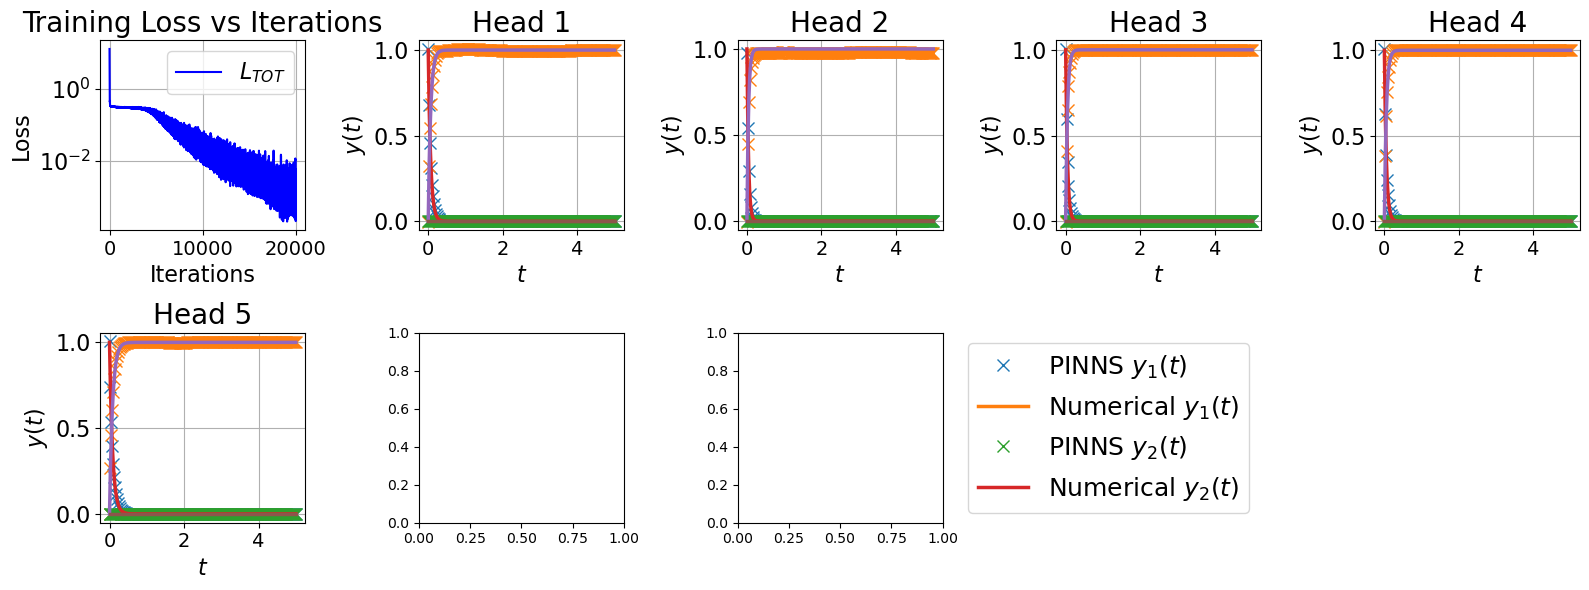

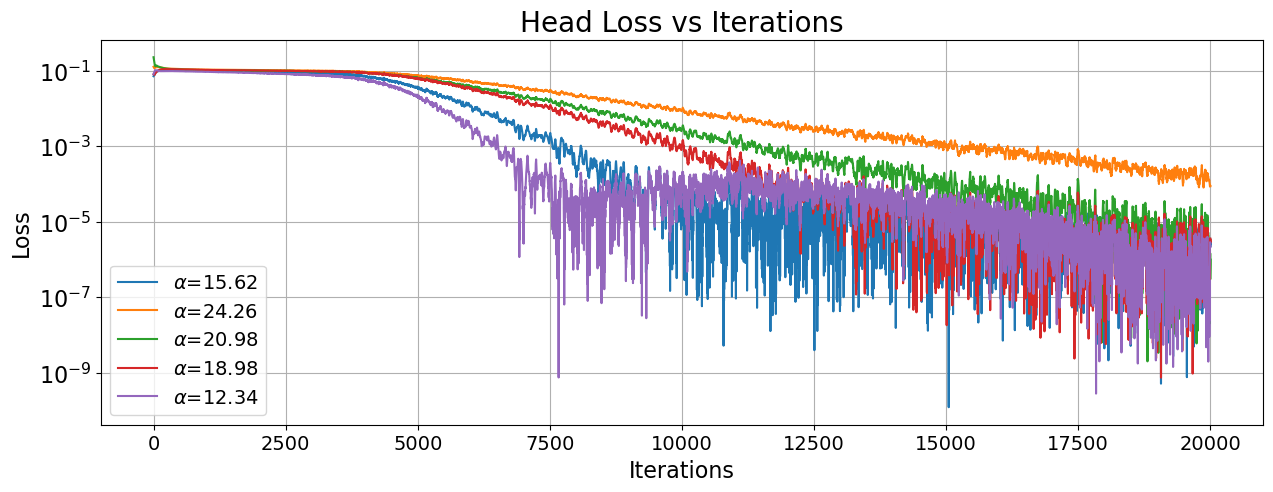

In [14]:
plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_fct,
                           trained_model=trained_model, IC_list=IC_list, A_list=A_list,
                           force=force_list, train_losses=loss_hist, device=dev)
plot_head_loss(loss_hist["head"], alpha_list)

In [15]:
model_name = "linear_new"
save_model(trained_model, formatted_datetime_int, equation_name, model_name,
           x_range, iterations, hid_lay, num_equations, num_heads, A_list,
           IC_list, force_list, alpha_list, loss_hist)

D:\Emilien\Documents\Cours\Master_Thesis\Harvard_Master_Thesis\model_history/Roberston/history_linear_new_2221600.json


# Train on the non linear function

In [21]:
from src.train import run_model_non_linear

In [40]:
num_heads = 1
equation_name = "duffing"

np.random.seed(42)
# generate the training stiffness parameter alpha
alpha_bounds = (1, 5)
def generate_alpha(k, alpha_bounds = alpha_bounds):
  alpha_list = np.zeros(k)
  for i in range(k):
    alpha_list[i] = np.random.uniform(alpha_bounds[0], alpha_bounds[1])
  return alpha_list
alpha_list = generate_alpha(num_heads)
alpha_list = [10]
beta = 0.5

def equation(t, y, alpha, beta=beta):
    if isinstance(y, torch.Tensor):
      yp = torch.zeros_like(y)
      force = torch.cos(t)
    elif isinstance(y, np.ndarray):
      yp = np.zeros_like(y)
      force = np.cos(t)
    yp[..., 0] = y[..., 1]
    yp[..., 1] = -0.1*y[..., 0] - alpha*y[..., 1] - beta*y[..., 0]**3 + force
    return yp

equation_list = [lambda t, y, Alpha=alpha: equation(t, y, Alpha) for alpha in alpha_list]

# training IC (random or not)
def random_IC(x_bound=[1.5, 2.5], y_bound=[0, 0]):
    ICx = np.random.uniform(x_bound[0], x_bound[1], 1)
    ICy = np.random.uniform(y_bound[0], y_bound[1], 1)
    return torch.tensor([ICx, ICy], device=dev)
#IC_list = [random_IC() for i in range(num_heads)]
IC_list = [torch.tensor([[1.], [0.5]], device=dev).double() for _ in range(num_heads)]

In [41]:
numerical_sol_fct = lambda x, v, alpha, beta: (solve_ivp(equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(alpha, beta), t_eval=x.squeeze(), method="Radau").y.T)
numerical_sol_list = [lambda x, IC=ic.detach().cpu().numpy(), Alpha=alpha, beta=beta: numerical_sol_fct(x, IC, Alpha, beta) for ic, alpha in zip(IC_list, alpha_list)]

In [42]:
x_range = [0, 5]
activation = "silu"
hid_lay = list(np.array([128, 128, 256, 512]))
reparametrization=True
num_equations = 2
iterations = 15000

In [43]:
sample_size = 200
lr = 1e-4
decay = True
verbose = True

# run model which has two non-coupled equations
loss_hist, trained_model, model_time = run_model_non_linear(iterations=iterations, x_range=x_range, lr=lr,
                                                            equation_list=equation_list, IC_list=IC_list,
                                                            hid_lay=hid_lay, activation=activation,
                                                            num_equations=num_equations, num_heads=num_heads,
                                                            sample_size = sample_size, decay=decay, dev=dev, verbose=verbose,
                                                            true_functs=None, reparametrization=reparametrization)

# date tag to save
from datetime import datetime
now = datetime.now()
# Format the date and time as a string in the format 'mmddhhmm'
formatted_datetime = now.strftime('%m%d%H%M')
# Convert the formatted string to an integer
formatted_datetime_int = int(formatted_datetime)

  0%|          | 0/10000 [00:00<?, ?it/s]

Iterations 0, L_total = 1.051134046692457, L_ODE = 1.051134046692457, L_IC = 0.0
Iterations 100, L_total = 0.42324502240298423, L_ODE = 0.42324502240298423, L_IC = 0.0
Iterations 200, L_total = 0.30273786034731703, L_ODE = 0.30273786034731703, L_IC = 0.0
Iterations 300, L_total = 0.15451295381666552, L_ODE = 0.15451295381666552, L_IC = 6.162975822039155e-33
Iterations 400, L_total = 0.06646165923596481, L_ODE = 0.06646165923596481, L_IC = 2.465190328815662e-32
Iterations 500, L_total = 0.07109900726847461, L_ODE = 0.07109900726847461, L_IC = 0.0
Iterations 600, L_total = 0.07033252701261118, L_ODE = 0.07033252701261118, L_IC = 0.0
Iterations 700, L_total = 0.01773245860027076, L_ODE = 0.01773245860027076, L_IC = 0.0
Iterations 800, L_total = 0.03350132731198311, L_ODE = 0.03350132731198311, L_IC = 0.0
Iterations 900, L_total = 0.020611603061300804, L_ODE = 0.020611603061300804, L_IC = 0.0
Iterations 1000, L_total = 0.018444053927607177, L_ODE = 0.018444053927607177, L_IC = 0.0
Iteratio

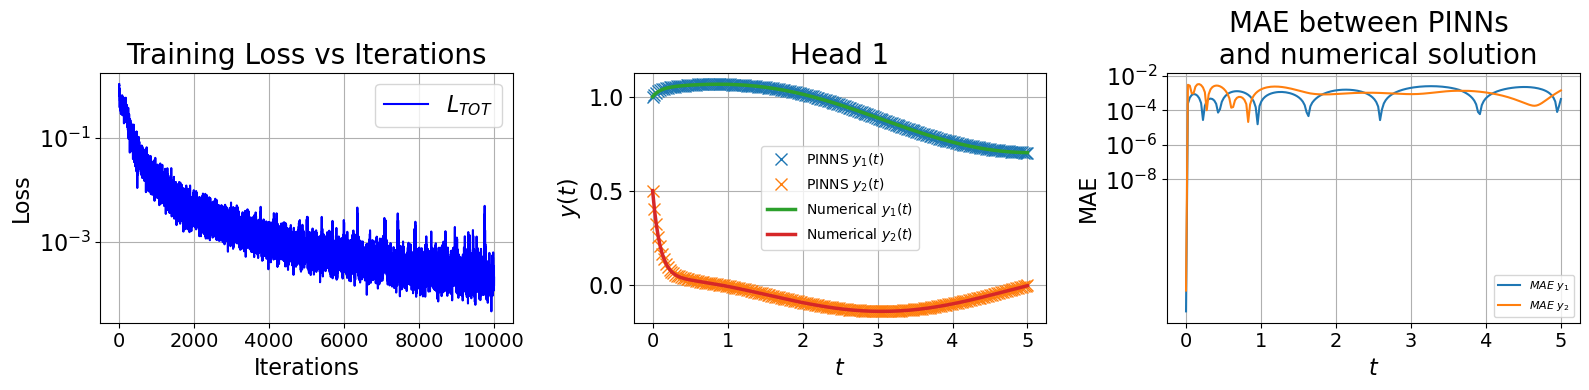

In [44]:
plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_list,
                           trained_model=trained_model, IC_list=IC_list,
                           A_list=None, force=None, train_losses=loss_hist,
                           device=dev, equation_list=equation_list, reparametrization=reparametrization)

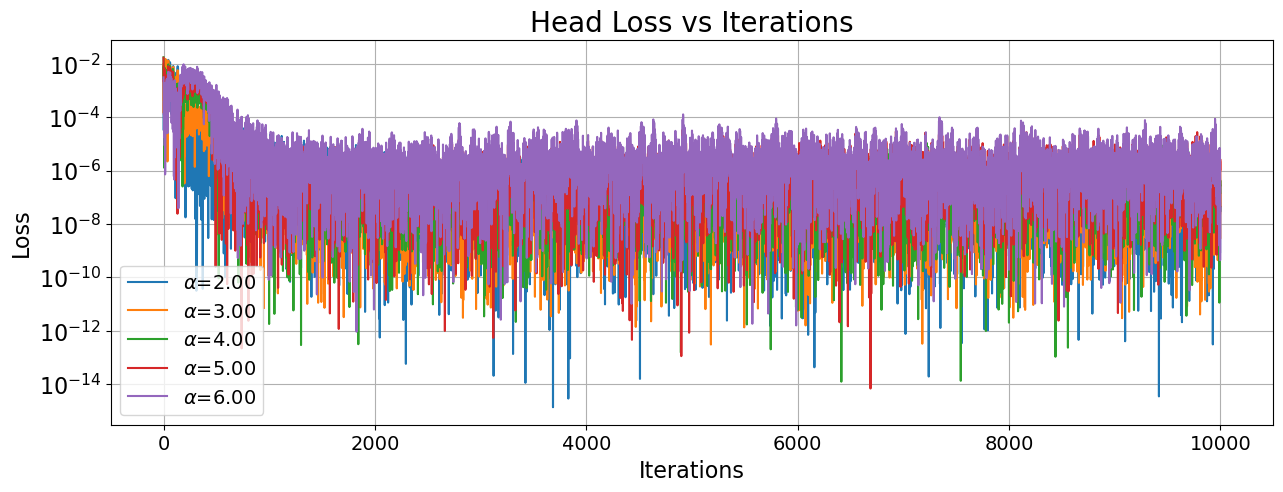

In [16]:
plot_head_loss(loss_hist["head"], alpha_list)

In [17]:
model_name = "nonlinear_repara"
A_list=[torch.tensor([np.nan])]
force_list = [torch.tensor([np.nan])]
save_model(trained_model, formatted_datetime_int, equation_name, model_name,
           x_range, iterations, hid_lay, num_equations, num_heads, A_list,
           IC_list, force_list, alpha_list, loss_hist)

D:\Emilien\Documents\Cours\Master_Thesis\Harvard_Master_Thesis\model_history/duffing/history_nonlinear_repara_2141608.json
